# Traveling Salesman Problem
Consider the following graph with four cities and the distances between them. Find the shortest
path that would enable the salesman to visit all the cities and return to its hometown. You can
choose your hometown among the four cities.
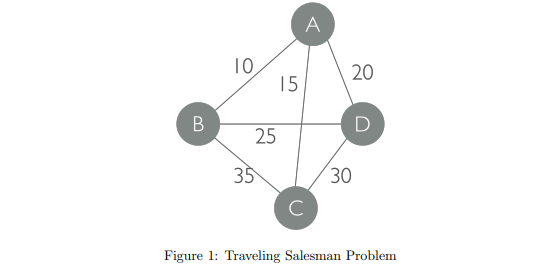
#### 2) Solve this problem using a quantum approximate optimization algorithm (QAOA) and report the result and your code whose filename should follow “QAOATSP” and the file format can be chosen by you (e.g. .py, .ipynb, ...). Discuss this result with the classical one.

### Choose A as hometown


### Outline for Approaching the TSP with QAOA

1. **Define the Graph**  
   Create a graph representation of the cities and the distances between them.

2. **Cost Hamiltonian**  
   Construct the cost Hamiltonian representing the TSP. In the TSP, the Hamiltonian should penalize high-cost routes and reward lower-cost ones.

3. **QAOA Circuit**  
   Implement the QAOA circuit, which includes applying the cost and mixer Hamiltonians alternately.

4. **Optimization**  
   Use a classical optimizer to optimize the parameters of the QAOA circuit.

5. **Sampling**  
   After optimization, sample from the final state to find the most likely solutions.

6. **Analysis**  
   Decode the solution from the quantum state to the actual routes and calculate the total distance.


In [1]:
!pip install qiskit qiskit-optimization qiskit_algorithms
!pip install qiskit-aer
!pip install psutil

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}


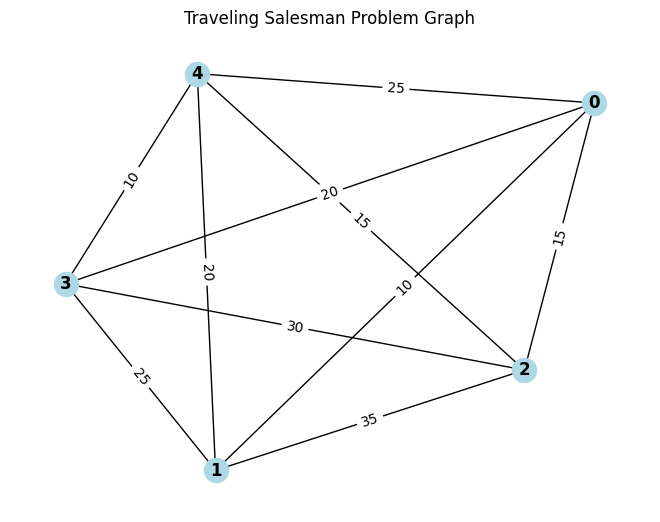

Optimal Parameters:  [[1.04388111 0.51280419]
 [0.89917    0.6119979 ]]


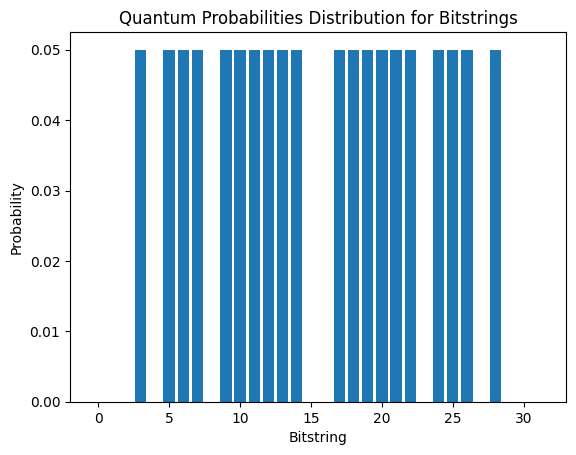


Most probable bitstring: 5
Binary or State Representation: [0, 0, 1, 0, 1]
Where the digits coorespond to the first two path choices: [A,B,C,D]


The shortest path starting from city 'A' is: A -> C -> E -> B -> A
The total distance of the shortest path is: 60 units.


Runtime of the code: 15.577746629714966 seconds
Memory usage: 215752.0 KB


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
import networkx as nx
import matplotlib.pyplot as plt
import time
import psutil

# Define the graph for the Traveling Salesman Problem (TSP)
# Each edge represents a path between two cities with an associated distance
edges = [(0, 1, 10), (0, 2, 15), (0, 3, 20), (1, 2, 35), (1, 3, 25), (2, 3, 30), (4,3,10), (4,2,15), (4,1,20), (4,0,25)]

# Define the mapping from city indices to labels
city_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}
print(city_labels)

# Define distances between cities for calculating total distance
distances = {tuple(sorted((city_labels[i], city_labels[j]))): w for i, j, w in edges}

graph = nx.Graph()
graph.add_weighted_edges_from(edges)

# Draw the graph with edge labels for distances
pos = nx.spring_layout(graph)  # positions for all nodes
nx.draw(graph, pos, with_labels=True, node_color='lightblue', font_weight='bold')
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
plt.title("Traveling Salesman Problem Graph")
plt.show()

# Start measuring time and memory
start_time = time.time()
process = psutil.Process()

# Define the number of qubits (cities) and the range of wires
num_nodes = graph.number_of_nodes()
wires = range(num_nodes)

# Define the cost and mixer Hamiltonians for the QAOA algorithm
cost_h, mixer_h = qaoa.maxcut(graph)

# Define the number of QAOA layers
num_qaoa_layers = 2  # Adjust this value as needed

# Define the QAOA layers
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

# Define the complete QAOA circuit
def circuit(params):
    for w in wires:
        qml.Hadamard(wires=w)
    for i in range(num_qaoa_layers):
        qaoa_layer(params[i][0], params[i][1])

# Initialize the quantum device for simulation
dev = qml.device('default.qubit', wires=len(wires))

# Define the cost function for optimization
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

# Initialize the optimizer with a specific learning rate
learning_rate = 0.01
optimizer = qml.GradientDescentOptimizer(stepsize=learning_rate)
steps = 200
params = np.array([[0.5, 0.5] for _ in range(num_qaoa_layers)], requires_grad=True)

# Optimize the parameters to minimize the cost function
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters: ", params)

# Add measurement to get the probabilities of each bitstring
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires=wires)

# Get the probabilities of each bitstring
probabilities = probability_circuit(params)

# Stop measuring time and memory
end_time = time.time()
memory_usage = process.memory_info().rss / 1024  # memory usage in KB

# Plot the quantum probabilities distribution for bitstrings
plt.bar(range(2 ** num_nodes), probabilities)
plt.title("Quantum Probabilities Distribution for Bitstrings")
plt.xlabel("Bitstring")
plt.ylabel("Probability")
plt.show()

# Visualize the quantum circuit
#print(qml.draw(circuit, expansion_strategy='device')(params))

# Decode the most probable bitstring into a path
most_probable_bitstring = np.argmax(probabilities)
print("\nMost probable bitstring: " +str(most_probable_bitstring))
path_indices = [int(bit) for bit in format(most_probable_bitstring, '0' + str(num_nodes) + 'b')]
print("Binary or State Representation: "+str(path_indices))
print("Where the digits coorespond to the first two path choices: [A,B,C,D,E]")
# Determine the order of cities from the bitstring

if sum(path_indices) != 2:
    raise ValueError('Not All Cities Visited')
    
# Placeholder for actual TSP decoding process
tour_indices = [i for i, bit in enumerate(path_indices) if bit == 1]

# Start city is 'A', index 0
start_city_index = 0
start_city_label = 'A'

# Ensure the start city is the first in the tour
if start_city_index not in tour_indices:
    tour_indices.insert(0, start_city_index)

# Check if all cities are visited, if not, add the missing city
all_cities = set(range(num_nodes))
visited_cities = set(tour_indices)
if all_cities != visited_cities:
    missing_city = list(all_cities - visited_cities)[0]
    # Check if the missing city connects to the last city in the current path
    if (tour_indices[-1], missing_city) in graph.edges():
        tour_indices.append(missing_city)

# Ensure the tour is a cycle by returning to the start
if tour_indices[-1] != start_city_index:
    tour_indices.append(start_city_index)

# Decode the tour indices into city labels
decoded_tour = [city_labels[index] for index in tour_indices]
    
# Calculate the total distance of the path
shortest_distance = 0
for i in range(len(decoded_tour) - 1):
    edge = tuple(sorted((decoded_tour[i], decoded_tour[i + 1])))
    shortest_distance += distances[edge]

# Close the tour by returning to the start city 'A'
if decoded_tour[-1] != 'A':
    edge = tuple(sorted((decoded_tour[-1], 'A')))
    shortest_distance += distances[edge]
    decoded_tour.append('A')


#print(decoded_tour)

# Print out the results with descriptive statements
print(f"\n\nThe shortest path starting from city '{start_city_label}' is: {' -> '.join(decoded_tour)}")
print(f"The total distance of the shortest path is: {shortest_distance} units.")
# Print out the runtime and memory usage
print(f"\n\nRuntime of the code: {end_time - start_time} seconds")
print(f"Memory usage: {memory_usage} KB")


In [8]:
most_probable_bitstring = np.argmax(probabilities)
bitstring_str = format(most_probable_bitstring, f'0{num_nodes}b')
path_indices = [int(bit) for bit in bitstring_str]
print("\nMost probable bitstring:", most_probable_bitstring)
print("Binary or State Representation:", path_indices)
print("Where the digits correspond to the next two cities after start city A: [A,B,C,D,E]")

# Assume city A (index 0) is always the start
start_city_index = 0
start_city_label = city_labels[start_city_index]

# We expect exactly 2 other cities selected in the bitstring (excluding A)
path_indices[start_city_index] = 0  # force A to 0 in bitstring
if sum(path_indices) != 2:
    raise ValueError(f"Invalid encoding: expected 2 cities selected (excluding A), got {sum(path_indices)}")

# Get the two selected cities after A
initial_cities = [i for i, bit in enumerate(path_indices) if bit == 1]

# Begin the tour with A
tour_indices = [start_city_index] + initial_cities

# Add remaining cities not in tour
for i in range(num_nodes):
    if i not in tour_indices:
        tour_indices.append(i)

# Make it a cycle
tour_indices.append(start_city_index)

# Decode to city labels
decoded_tour = [city_labels[i] for i in tour_indices]

# Compute distance
total_distance = 0
for i in range(len(decoded_tour) - 1):
    edge = tuple(sorted((decoded_tour[i], decoded_tour[i + 1])))
    try:
        total_distance += distances[edge]
    except KeyError:
        print(f"❌ Missing distance for edge: {edge}")
        total_distance = float('inf')
        break

# Output
print(f"\n✅ Completed tour starting at '{start_city_label}': {' -> '.join(decoded_tour)}")
print(f"Total distance: {total_distance} units")



Most probable bitstring: 5
Binary or State Representation: [0, 0, 1, 0, 1]
Where the digits correspond to the next two cities after start city A: [A,B,C,D,E]

✅ Completed tour starting at 'A': A -> C -> E -> B -> D -> A
Total distance: 95 units


## Checking Consistency

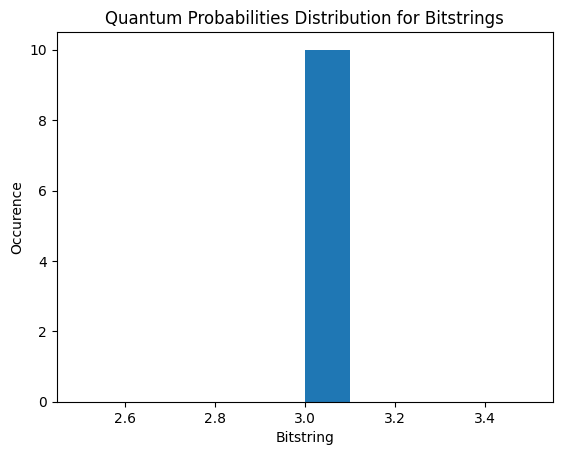

In [9]:
def run_simulation():
    results = []

    # Define the graph for the Traveling Salesman Problem (TSP)
    # Each edge represents a path between two cities with an associated distance
    edges = [(0, 1, 10), (0, 2, 15), (0, 3, 20), (1, 2, 35), (1, 3, 25), (2, 3, 30)]

    # Define the mapping from city indices to labels
    city_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    #print(city_labels)

    # Define distances between cities for calculating total distance
    distances = {
        ('A', 'B'): 10,
        ('A', 'C'): 15,
        ('A', 'D'): 20,
        ('B', 'C'): 35,
        ('B', 'D'): 25,
        ('C', 'D'): 30
    }
    graph = nx.Graph()
    graph.add_weighted_edges_from(edges)

    # Draw the graph with edge labels for distances
    pos = nx.spring_layout(graph)  # positions for all nodes
    #nx.draw(graph, pos, with_labels=True, node_color='lightblue', font_weight='bold')
    #labels = nx.get_edge_attributes(graph, 'weight')
    #nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    #plt.title("Traveling Salesman Problem Graph")
    #plt.show()

    # Start measuring time and memory
    start_time = time.time()
    process = psutil.Process()

    # Define the number of qubits (cities) and the range of wires
    num_nodes = graph.number_of_nodes()
    wires = range(num_nodes)

    # Define the cost and mixer Hamiltonians for the QAOA algorithm
    cost_h, mixer_h = qaoa.maxcut(graph)

    # Define the number of QAOA layers
    num_qaoa_layers = 2  # Adjust this value as needed

    # Define the QAOA layers
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)

    # Define the complete QAOA circuit
    def circuit(params):
        for w in wires:
            qml.Hadamard(wires=w)
        for i in range(num_qaoa_layers):
            qaoa_layer(params[i][0], params[i][1])

    # Initialize the quantum device for simulation
    dev = qml.device('default.qubit', wires=len(wires))

    # Define the cost function for optimization
    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost_h)
    
    # Initialize the quantum device for simulation
    dev = qml.device('default.qubit', wires=len(wires))

    # Initialize the optimizer with a specific learning rate
    learning_rate = 0.01
    optimizer = qml.GradientDescentOptimizer(stepsize=learning_rate)
    params = np.array([[0.5, 0.5] for _ in range(num_qaoa_layers)], requires_grad=True)

    # Optimize the parameters to minimize the cost function
    for i in range(steps):
        params = optimizer.step(cost_function, params)

    # Add measurement to get the probabilities of each bitstring
    @qml.qnode(dev)
    def probability_circuit(params):
        circuit(params)
        return qml.probs(wires=wires)

    # Get the probabilities of each bitstring
    probabilities = probability_circuit(params)

    # Decode the most probable bitstring into a path
    most_probable_bitstring = np.argmax(probabilities)
    path_indices = [int(bit) for bit in format(most_probable_bitstring, '0' + str(num_nodes) + 'b')]

    #print("Binary or State Representation: "+str(path_indices))
    #print("Where the digits coorespond to the first two path choices: [A,B,C,D]")
    # Determine the order of cities from the bitstring

    if sum(path_indices) != 2:
        raise ValueError('Not All Cities Visited')

    # Placeholder for actual TSP decoding process
    tour_indices = [i for i, bit in enumerate(path_indices) if bit == 1]

    # Start city is 'A', index 0
    start_city_index = 0
    start_city_label = 'A'

    # Ensure the start city is the first in the tour
    if start_city_index not in tour_indices:
        tour_indices.insert(0, start_city_index)

    # Check if all cities are visited, if not, add the missing city
    all_cities = set(range(num_nodes))
    visited_cities = set(tour_indices)
    if all_cities != visited_cities:
        missing_city = list(all_cities - visited_cities)[0]
        # Check if the missing city connects to the last city in the current path
        if (tour_indices[-1], missing_city) in graph.edges():
            tour_indices.append(missing_city)

    # Ensure the tour is a cycle by returning to the start
    if tour_indices[-1] != start_city_index:
        tour_indices.append(start_city_index)

    # Decode the tour indices into city labels
    decoded_tour = [city_labels[index] for index in tour_indices]

    # Calculate the total distance of the path
    shortest_distance = 0
    for i in range(len(decoded_tour) - 1):
        edge = tuple(sorted((decoded_tour[i], decoded_tour[i + 1])))
        shortest_distance += distances[edge]

    # Close the tour by returning to the start city 'A'
    if decoded_tour[-1] != 'A':
        edge = tuple(sorted((decoded_tour[-1], 'A')))
        shortest_distance += distances[edge]
        decoded_tour.append('A')

    # Append results to the list
    results={
        "most_probable_bitstring": most_probable_bitstring,
        "decoded_tour": decoded_tour,
        "shortest_distance": shortest_distance,
    }

    return results

# Run the simulation 100 times
bitstring_array = []
for _ in range(10):
    simulation_results = run_simulation()
    bitstring_array.append(simulation_results["most_probable_bitstring"])

# Plot the quantum probabilities distribution for bitstrings for all runs
plt.hist(bitstring_array)
plt.title(f"Quantum Probabilities Distribution for Bitstrings")
plt.xlabel("Bitstring")
plt.ylabel("Occurence")
plt.show()

Therefore it can be seen that the number of layers and steps along with the choice of hyperparameters for optimization leads to a single optimal solution of Bitstring 3 which is associated with the path: A -> C -> D -> B -> A.

# Comparison With Classical Results

Both the Classical and Quantum Approach found the same minimum path of A -> C -> D -> B -> A or the equivalent but reversed version. This indicates that both methodologies produce the optimal path for the TSP problem with a length of 80 to reach each city.

In terms of time complexity the Quantum Approach is dependant on the number of steps times the number of layers as can been seen by the for loops this means it is approximately O(N). While the classical approach had a time complexity of O(N^2 * 2^N). 

However, since it takes a significant amount of time to interface with the Pennylane library and setup the optimized circuit the quantum approach takes significantly more time and memory to reach the optimal solution.

In order to see a specific quantum advantage over a classical algorithmic approach it may require a much larger graph or be run locally either simulated or on a Quantum Computer. 

# Documentation of the Quantum implementation.
### Why QAOA Works for TSP

#### Quantum Superposition and Exploration
- QAOA prepares a quantum state in a superposition, enabling simultaneous exploration of numerous solutions, a unique quantum computation feature.

#### Encoding the Problem into a Hamiltonian
- The TSP is encoded into a cost Hamiltonian, aligning each solution (route) with a quantum state. The optimal TSP solution correlates with the Hamiltonian's lowest energy state.

#### Quantum Interference for Optimal Solutions
- QAOA uses variational parameters to manipulate quantum states, employing quantum interference to enhance probabilities of optimal solutions.

#### Hybrid Quantum-Classical Approach
- The algorithm optimizes quantum circuit parameters using classical algorithms, combining quantum state manipulation with classical computational power.

### Specific Approach in the Code

#### Graph Representation of TSP
- The TSP is visualized as a weighted graph, with nodes as cities and edges as paths, forming the basis for the cost Hamiltonian.

#### QAOA Circuit Construction
- The QAOA circuit, composed of layers based on cost and mixer Hamiltonians, evolves quantum states to associate lower energy states with shorter TSP paths.

#### Parameter Optimization
- Parameters in the QAOA circuit are fine-tuned using gradient descent to minimize the cost Hamiltonian's expected value, corresponding to shorter TSP paths.

#### Measuring and Analyzing Output
- Post-optimization, the final state is measured to yield a probability distribution over solutions. The path with the highest probability is proposed as the answer.

The code demonstrates QAOA's application to the TSP, showcasing how quantum computing's capabilities can be harnessed for combinatorial optimization.


## Code Documentation

### Graph Setup for TSP

```python
edges = [(0, 1, 10), (0, 2, 15), (0, 3, 20), (1, 2, 35), (1, 3, 15), (2, 3, 30)]
city_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
distances = { ... } # distances between cities

graph = nx.Graph()
graph.add_weighted_edges_from(edges)
```

- **Graph Definition**: The TSP is represented as a graph. Cities are nodes, and edges denote paths with weights indicating distances.
- **City Labels**: A mapping from numeric indices to city labels for readability.
- **Distance Mapping**: A dictionary to store distances between each pair of cities.

### Visualization of TSP Graph

```python
nx.draw(graph, pos, with_labels=True, ...)
```

- **Graph Drawing**: Uses `networkx` and `matplotlib` to visualize the TSP graph with cities as nodes and labeled edges indicating distances.

### QAOA Circuit Setup

```python
num_nodes = graph.number_of_nodes()
wires = range(num_nodes)
cost_h, mixer_h = qaoa.maxcut(graph)
```

- **Qubit Representation**: Each city (node) is represented by a qubit.
- **Hamiltonian Initialization**: Initializing cost and mixer Hamiltonians using `qaoa.maxcut`, which is a common method for translating combinatorial problems into a quantum framework.

### QAOA Layers and Circuit

```python
def qaoa_layer(gamma, alpha): ...
def circuit(params): ...
```

- **Layer Definition**: Defines a function to apply cost and mixer Hamiltonians to the qubits.
- **Circuit Definition**: Constructs the QAOA circuit with alternating layers of Hamiltonians.

### Optimization Process

```python
optimizer = qml.GradientDescentOptimizer()
params = np.random.rand(2 * num_nodes)

for i in range(steps):
    params = optimizer.step(cost_function, params)
```

- **Optimizer Choice**: Gradient descent is used for optimizing the parameters in the QAOA circuit.
- **Parameter Initialization and Optimization**: Parameters are randomly initialized and iteratively optimized to minimize the cost function.

### Probability Distribution and Path Decoding

```python
probabilities = probability_circuit(params)
most_probable_bitstring = np.argmax(probabilities)
path_indices = ...
```

- **Probability Measurement**: After optimization, the quantum circuit's output state probabilities are measured.
- **Bitstring to Path Conversion**: The most probable bitstring is translated back into a path representing a potential solution to the TSP.

### Validating and Completing the Tour

```python
if all_cities != visited_cities: ...
if tour_indices[-1] != start_city_index: ...
```

- **Tour Validation**: Ensures that the decoded path visits each city exactly once and forms a valid cycle.
- **Tour Completion**: Adds any missing city to the tour and ensures it returns to the start city.

### Calculating Total Distance

```python
for i in range(len(decoded_tour) - 1): ...
```

- **Distance Calculation**: Computes the total distance of the tour based on the distances between consecutive cities.

### Output

```python
print(f"The shortest path starting from city '{start_city_label}' is: {' -> '.join(decoded_tour)}")
```

- **Final Result**: Displays the computed shortest path and its total distance, providing a potential solution to the TSP based on the QAOA output.

---

## References

1. **PennyLane's QAOA Tutorial**  
   Learn more about QAOA with PennyLane's comprehensive guide and tutorial.  
   [PennyLane QAOA Tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_intro/)

2. **Quantum Approximate Optimization Algorithms on the TSP**  
   An insightful article exploring the application of QAOA to the Traveling Salesman Problem.  
   [Quantum Approximate Optimization Algorithms on the TSP - Medium](https://medium.com/mit-6-s089-intro-to-quantum-computing/quantum-approximate-optimization-algorithms-on-the-traveling-salesman-problem-703b8aee6624)

3. **QAOA for Max-Cut and Beyond**  
   A comprehensive research paper providing in-depth analysis and application of QAOA.  
   [QAOA for Max-Cut and Beyond - Stanford University](https://cs269q.stanford.edu/projects2019/DudasHenry_Y.pdf)
